In [4]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples

# Loading and Saving Data

In [9]:
import jhu
import covidtracking
import states
import sys

def load_data():

    # world data
    world = jhu.load_world()

    pop = {
        'Italy': 60.48e6,
        'US': 3.27e8,
    }

    data = {
        'Italy': world.Italy.tot,
        'US': world.US.tot
    }

    # US state data
    US = covidtracking.load_us()
    traits = states.uga_traits()

    state_pop = { k: traits.totalpop[k] for k in traits.index }
    state_data = { k: US[k] for k in US.columns.unique(level=0) }

    # combine them
    data = dict(data, **state_data)
    pop = dict(pop, **state_pop)
    
    return data, pop


def save_samples(place, mcmc_samples, post_pred_samples):
    # Save samples
    filename = f'out/{place}_samples.npz'
    np.savez(filename, mcmc_samples=mcmc_samples, post_pred_samples=post_pred_samples)

    # Write diagnostics to file
    filename = f'out/{place}_summary.txt'
    orig_stdout = sys.stdout
    with open(filename, 'w') as f:
        sys.stdout = f
        mcmc.print_summary()

    sys.stdout = orig_stdout
    
def load_samples(place):
    filename = f'out/{place}_samples.npz'
    x = np.load(filename, allow_pickle=True)
    mcmc_samples = x['mcmc_samples'].item()
    post_pred_samples = x['post_pred_samples'].item()
    return mcmc_samples, post_pred_samples

# Run Inference

In [12]:
data, pop = load_data()

prob_models = {
    'SIR': SIR_stochastic,
    'SEIR': SEIR_stochastic
}

model = 'SEIR'

prob_model = prob_models[model]

places = ['Italy', 'US', 'WA', 'NY', 'MA']


for place in places:

    start = pd.Timestamp('2020-03-04')
    confirmed = data[place].confirmed[start:]
    start = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    args = {
        'N': N,
        'T': T,
        'drift_scale': 2e-1,
        'det_conc': 100,
    }

    kernel = NUTS(prob_model,
                  init_strategy = numpyro.infer.util.init_to_median())

    mcmc = MCMC(kernel, 
                num_warmup=1000, 
                num_samples=1000, 
                num_chains=1)

    mcmc.run(jax.random.PRNGKey(2), 
             obs = confirmed.values,
             **args)

    mcmc.print_summary()
    mcmc_samples = mcmc.get_samples()

    # Posterior predictive samples for visualization
    args['drift_scale'] = 0 # set drift to zero for forecasting
    post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
    post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

    save_samples(place,
                 mcmc_samples, 
                 post_pred_samples)

sample: 100%|██████████| 2000/2000 [01:57<00:00, 17.00it/s, 255 steps of size 1.49e-02. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0   9114.52   9918.70   6767.62      6.00  19258.08    503.18      1.00
        I0   6960.94   1292.88   6798.11   4973.83   9086.32    416.66      1.00
   beta[0]      1.54      0.94      1.32      0.34      2.71    281.68      1.01
   beta[1]      1.56      1.00      1.31      0.35      2.76    343.12      1.01
   beta[2]      1.58      0.97      1.36      0.41      2.71    382.25      1.01
   beta[3]      1.61      1.01      1.37      0.42      2.74    439.11      1.01
   beta[4]      1.65      0.99      1.39      0.39      2.82    543.56      1.00
   beta[5]      1.69      1.01      1.45      0.46      3.02    644.92      1.00
   beta[6]      1.71      0.97      1.47      0.44      3.02    704.85      1.00
   beta[7]      1.72      1.04      1.50      0.49      2.90    754.35      1.00
   beta[8]      1.68      0.95      1.46      0.41      2.76    755.59      1.00
   beta[9]      1.60      0

sample: 100%|██████████| 2000/2000 [02:03<00:00, 16.25it/s, 127 steps of size 1.07e-02. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    580.73    540.70    448.57      1.47   1199.84    367.14      1.00
        I0    384.46     74.33    373.85    271.19    491.34    437.27      1.00
   beta[0]      2.07      1.14      1.81      0.55      3.50    403.58      1.00
   beta[1]      2.13      1.19      1.85      0.48      3.55    474.63      1.00
   beta[2]      2.18      1.25      1.93      0.64      3.52    551.09      1.00
   beta[3]      2.28      1.29      1.97      0.80      3.86    581.56      1.00
   beta[4]      2.36      1.39      2.06      0.77      3.95    585.35      1.00
   beta[5]      2.39      1.35      2.12      0.79      4.08    575.14      1.00
   beta[6]      2.43      1.41      2.13      0.74      3.98    652.43      1.00
   beta[7]      2.45      1.44      2.17      0.78      4.09    639.98      1.00
   beta[8]      2.56      1.45      2.23      0.90      4.30    577.67      1.00
   beta[9]      2.71      1

sample: 100%|██████████| 2000/2000 [02:07<00:00, 15.74it/s, 255 steps of size 1.31e-02. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    214.96    195.16    157.74      1.75    445.54    541.59      1.00
        I0    125.18     24.23    121.98     87.14    161.01    414.38      1.00
   beta[0]      1.59      0.95      1.35      0.36      2.81    320.65      1.01
   beta[1]      1.59      0.93      1.37      0.44      2.84    399.74      1.00
   beta[2]      1.70      0.97      1.45      0.48      3.05    507.72      1.00
   beta[3]      1.88      1.07      1.60      0.43      3.28    552.95      1.00
   beta[4]      2.05      1.10      1.75      0.59      3.66    596.76      1.00
   beta[5]      2.16      1.13      1.89      0.67      3.80    595.88      1.00
   beta[6]      2.15      1.13      1.90      0.65      3.70    637.57      1.00
   beta[7]      1.97      1.00      1.73      0.62      3.44    582.37      1.00
   beta[8]      1.76      0.90      1.53      0.55      3.11    600.74      1.00
   beta[9]      1.53      0

sample: 100%|██████████| 2000/2000 [02:14<00:00, 14.84it/s, 255 steps of size 1.14e-02. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    243.62    165.39    205.36     68.70    400.14    228.71      1.01
        I0     18.24      4.41     17.41     11.85     24.95    607.27      1.00
   beta[0]      2.13      0.97      1.94      0.80      3.51    251.60      1.02
   beta[1]      2.09      0.88      1.94      0.79      3.14    466.19      1.00
   beta[2]      1.99      0.81      1.87      0.85      3.04    530.76      1.00
   beta[3]      1.91      0.78      1.77      0.70      2.85    484.05      1.00
   beta[4]      1.88      0.80      1.72      0.73      2.95    440.76      1.00
   beta[5]      2.00      0.91      1.86      0.81      3.28    374.85      1.00
   beta[6]      2.21      1.02      1.99      0.82      3.56    314.73      1.00
   beta[7]      2.55      1.20      2.33      0.83      3.98    363.01      1.00
   beta[8]      2.97      1.50      2.70      1.03      4.86    332.15      1.00
   beta[9]      3.43      1

sample: 100%|██████████| 2000/2000 [02:05<00:00, 15.96it/s, 255 steps of size 1.60e-02. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0     25.35     30.30     15.90      0.03     56.80    293.71      1.00
        I0      9.92      2.81      9.36      5.77     13.80    459.79      1.00
   beta[0]      3.70      1.36      3.44      1.75      5.82    329.57      1.02
   beta[1]      3.65      1.27      3.39      1.79      5.67    498.33      1.01
   beta[2]      3.32      1.09      3.10      1.71      4.95    624.92      1.00
   beta[3]      2.84      0.93      2.71      1.50      4.12    677.41      1.00
   beta[4]      2.19      0.72      2.06      1.22      3.32    665.59      1.00
   beta[5]      1.62      0.55      1.53      0.81      2.44    603.58      1.00
   beta[6]      1.28      0.45      1.21      0.62      1.98    633.85      1.00
   beta[7]      1.11      0.40      1.05      0.48      1.66    605.51      1.00
   beta[8]      1.04      0.40      0.98      0.45      1.63    661.80      1.00
   beta[9]      1.05      0

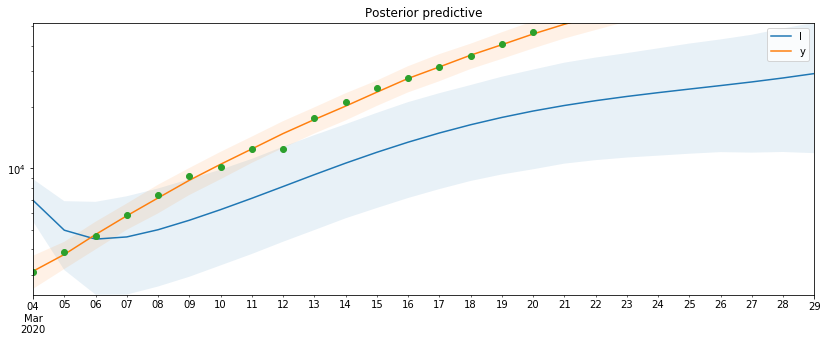

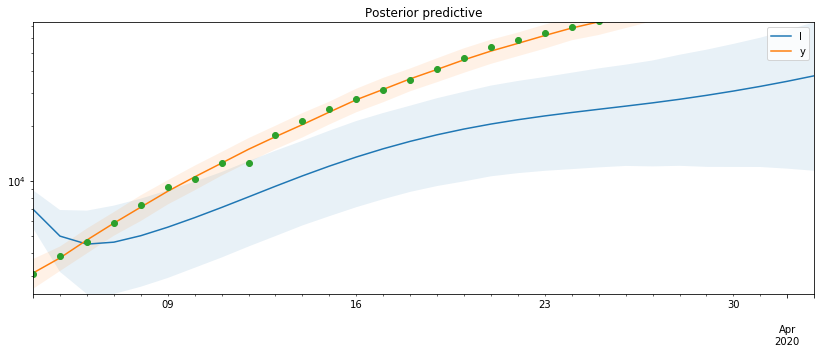

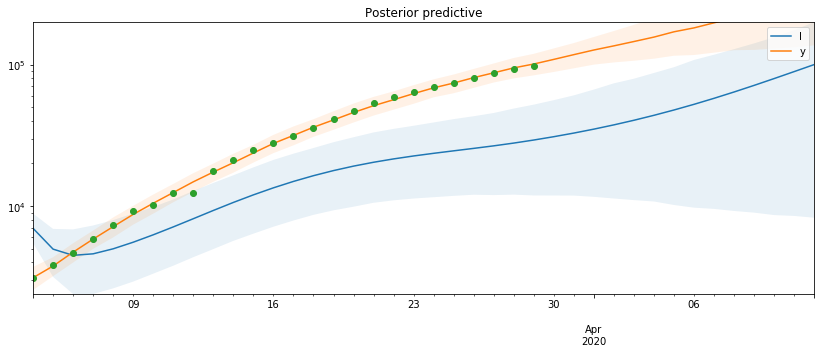

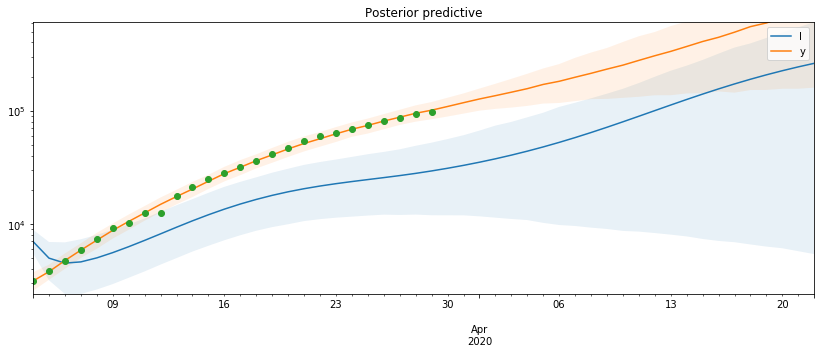

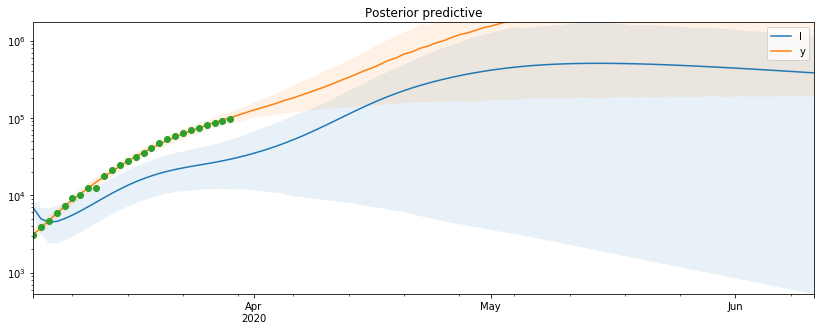

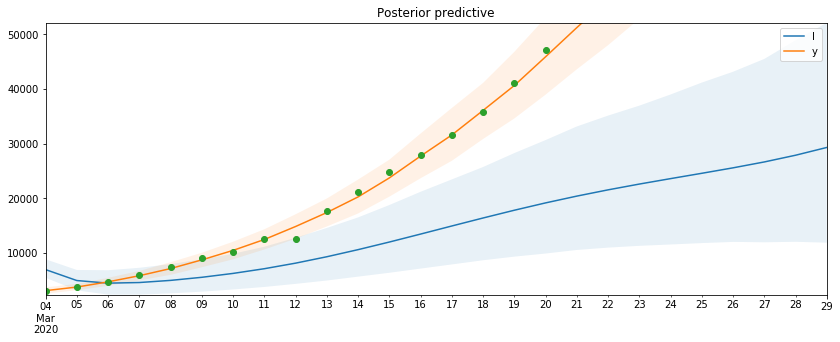

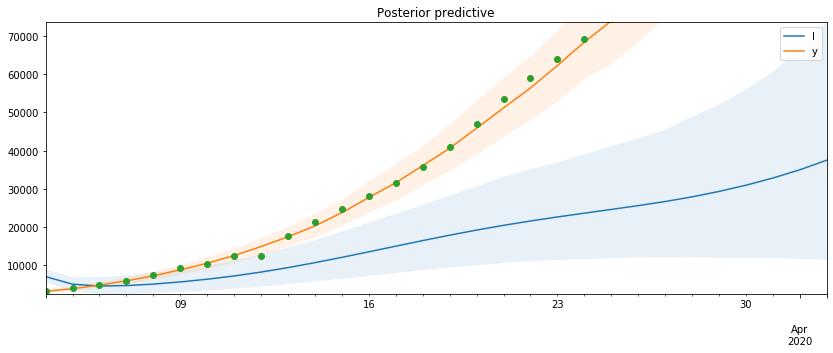

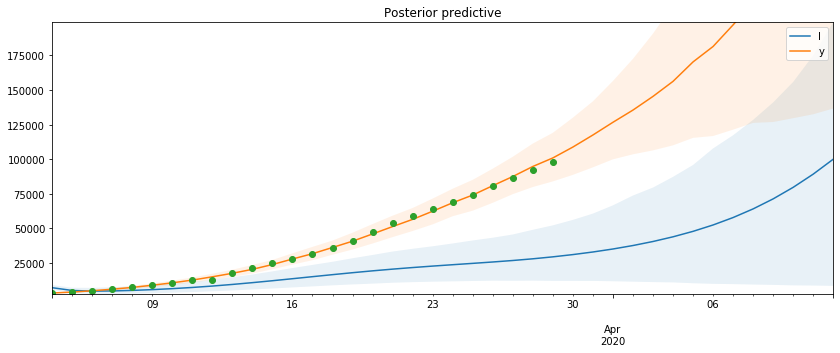

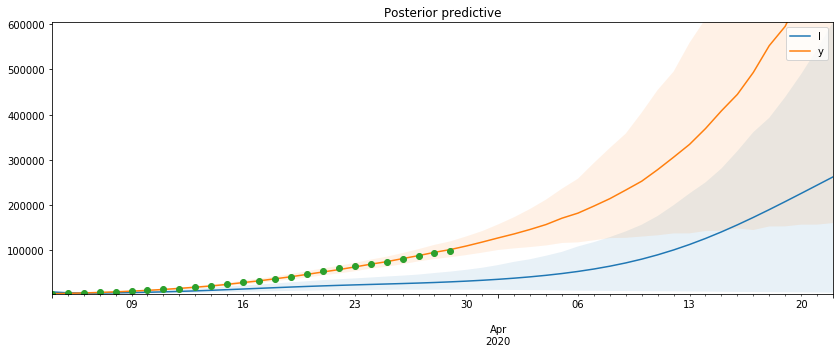

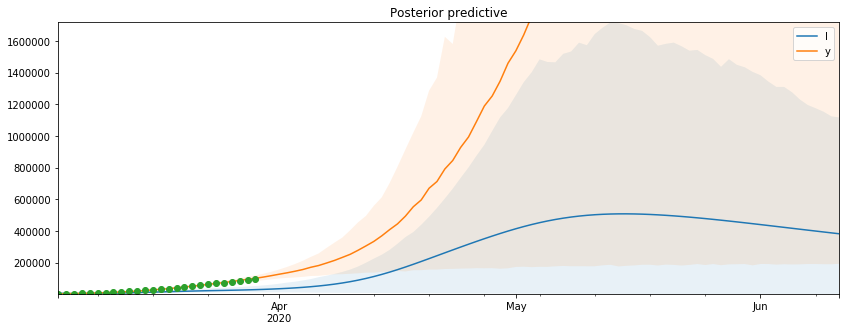

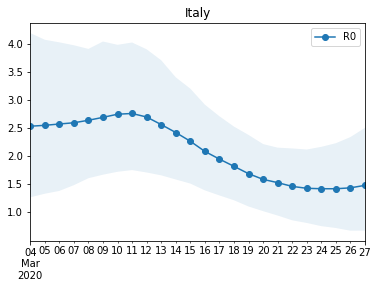

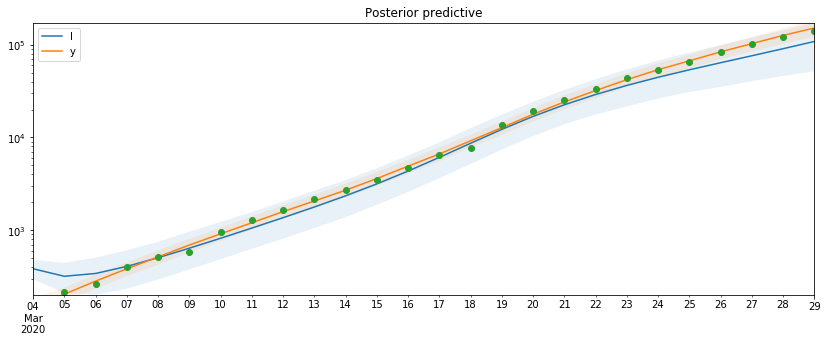

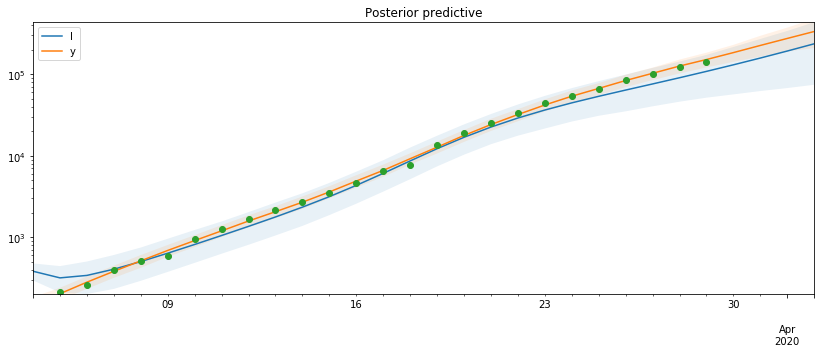

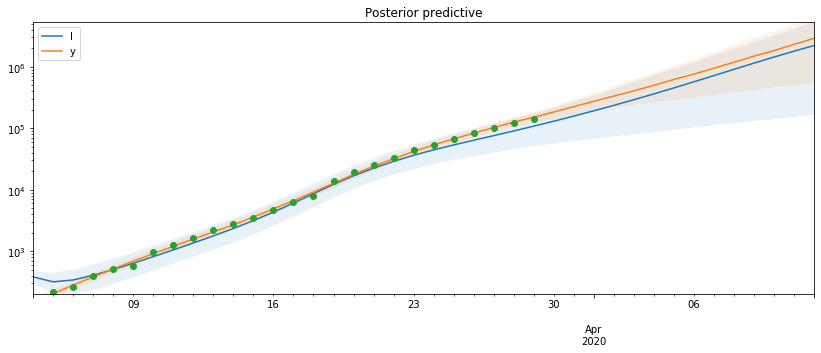

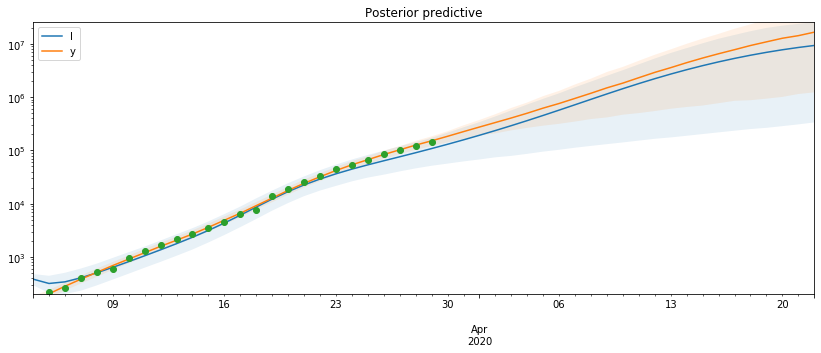

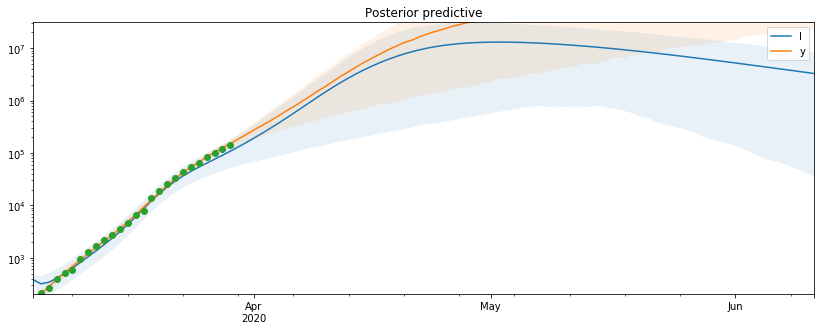

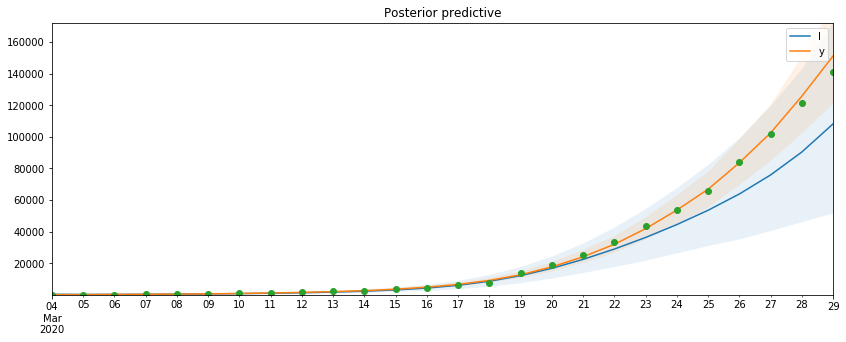

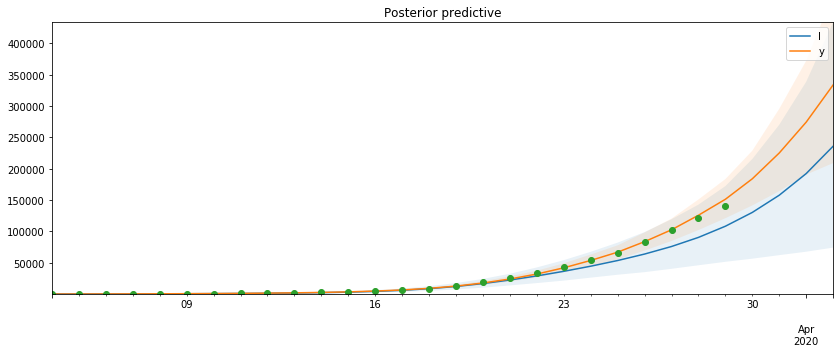

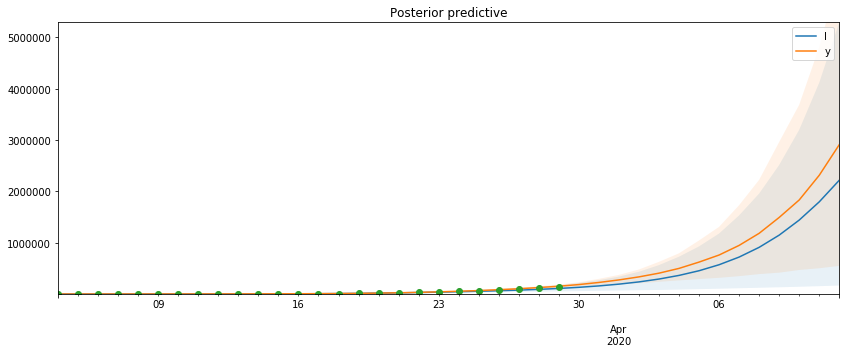

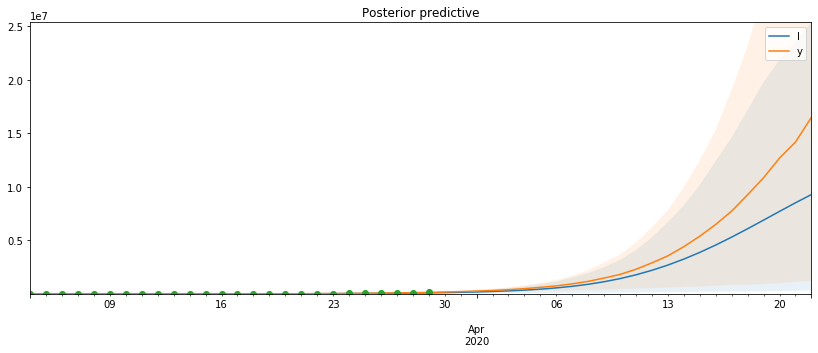

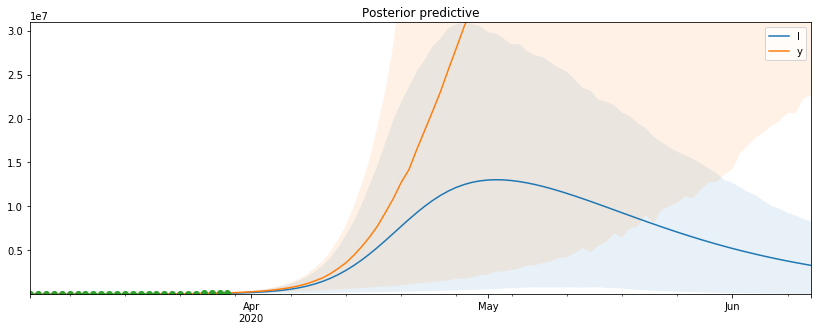

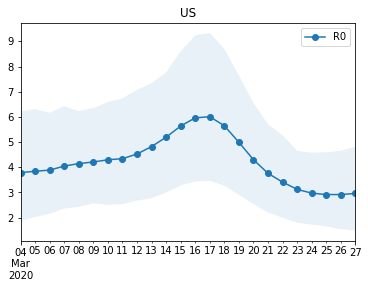

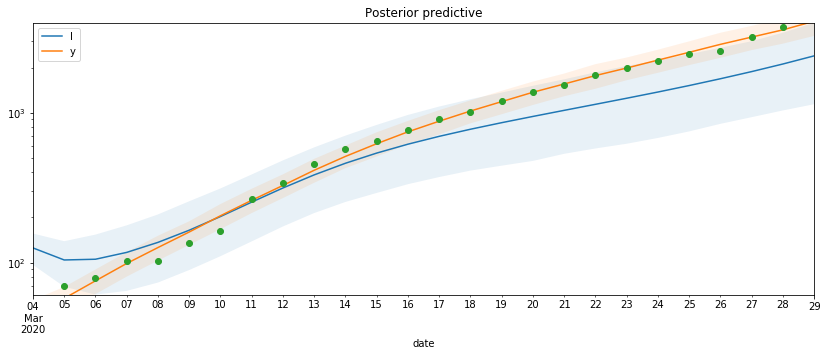

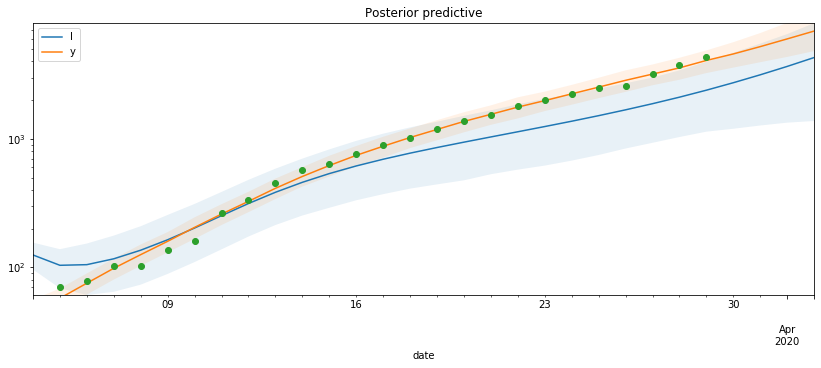

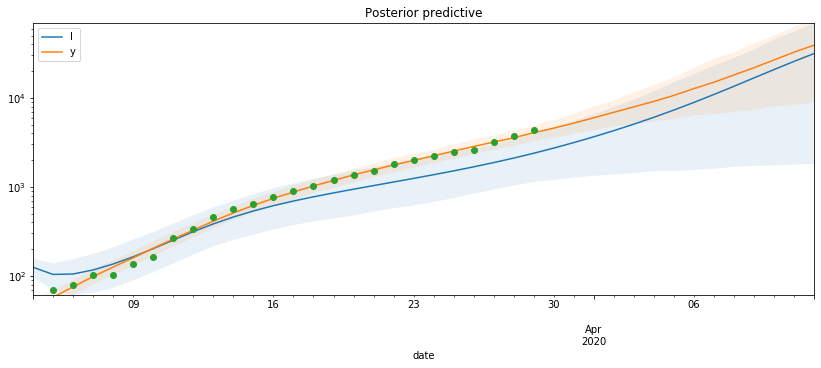

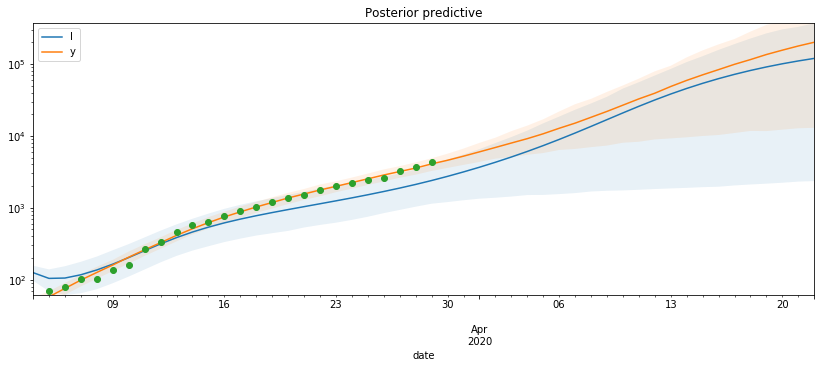

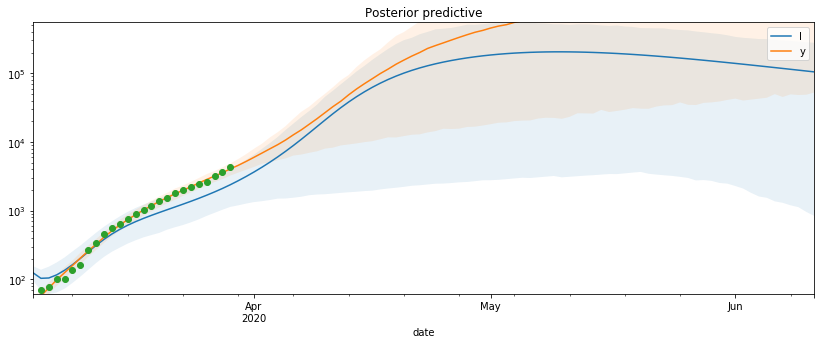

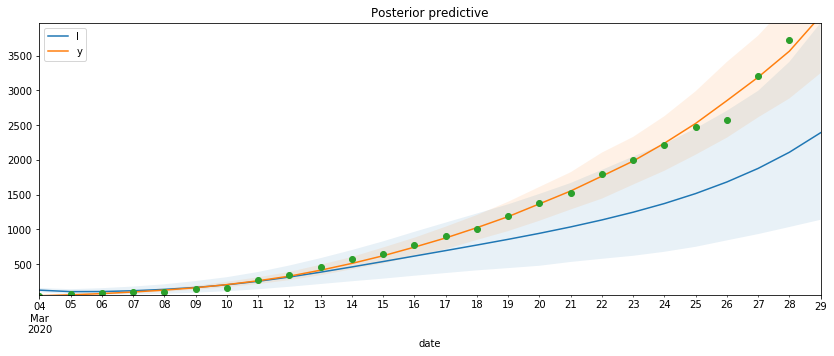

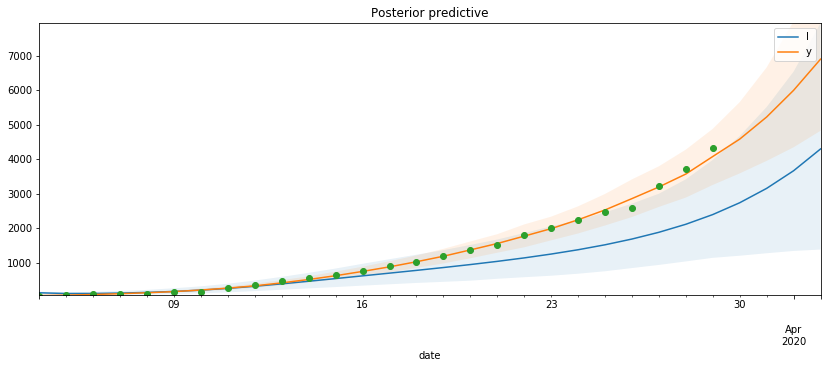

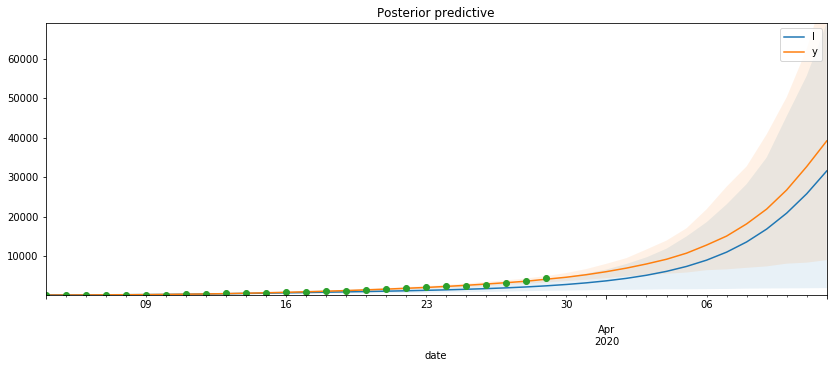

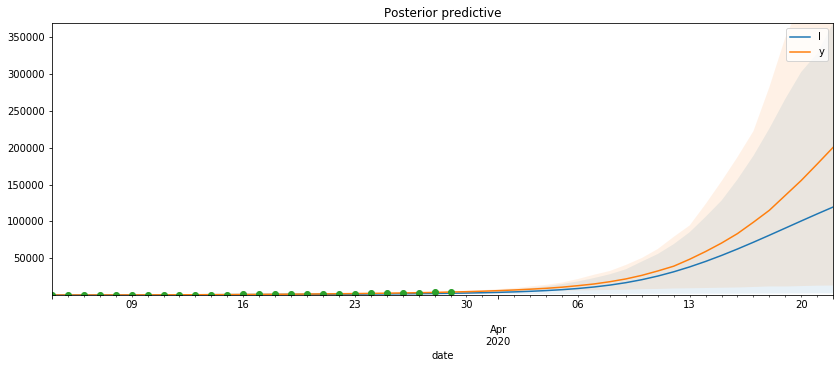

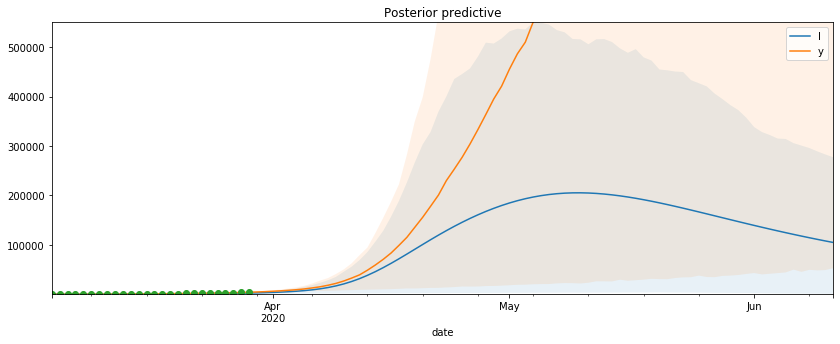

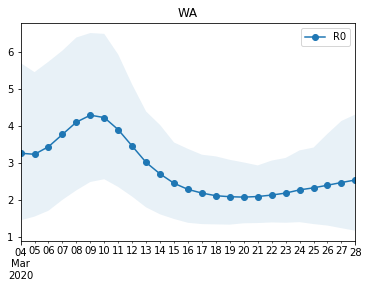

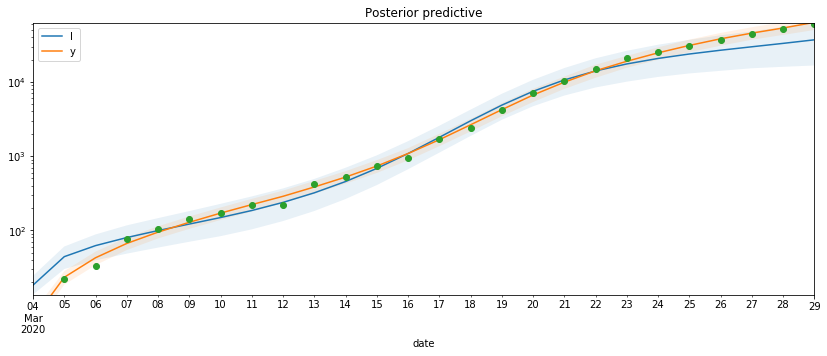

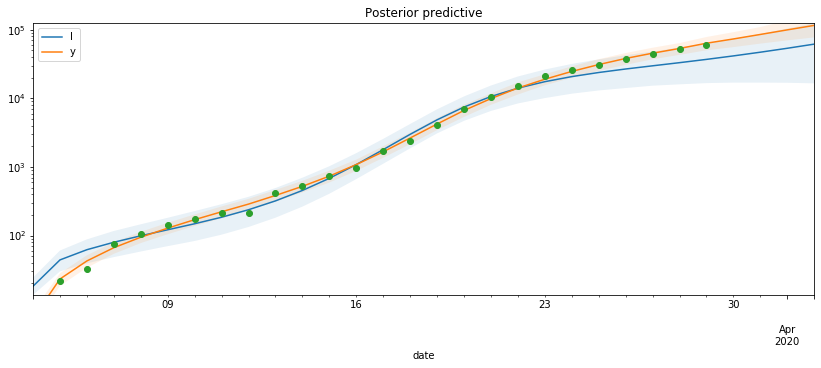

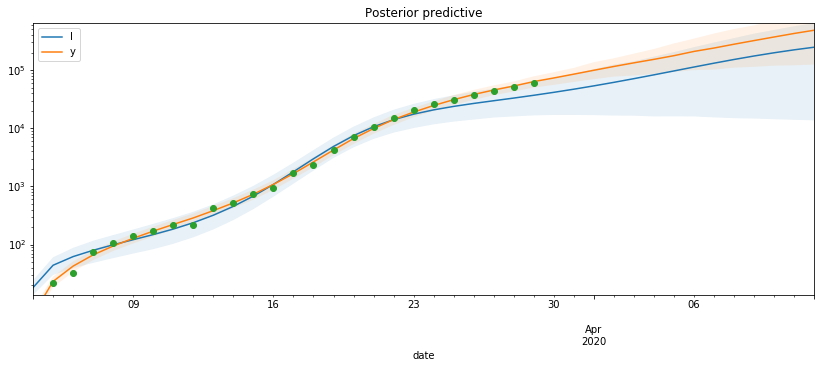

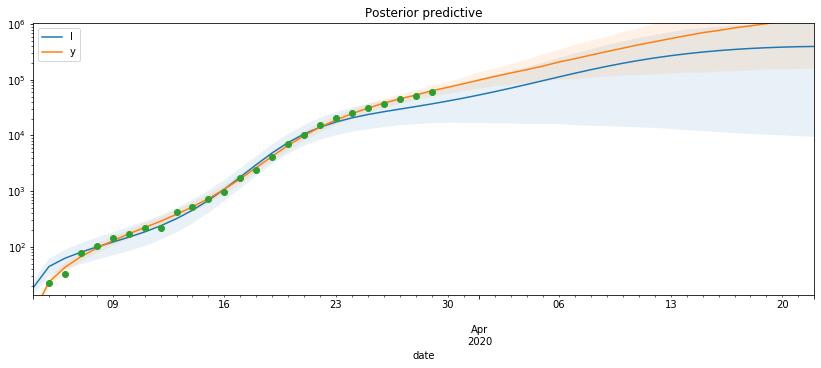

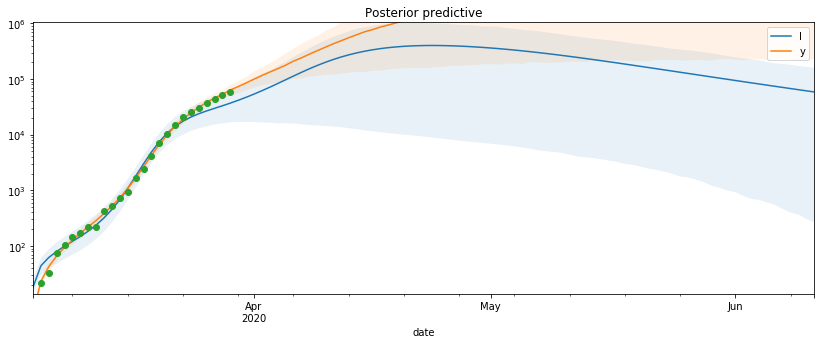

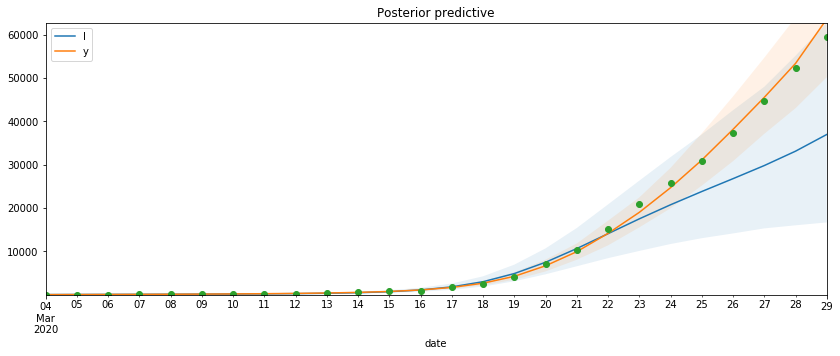

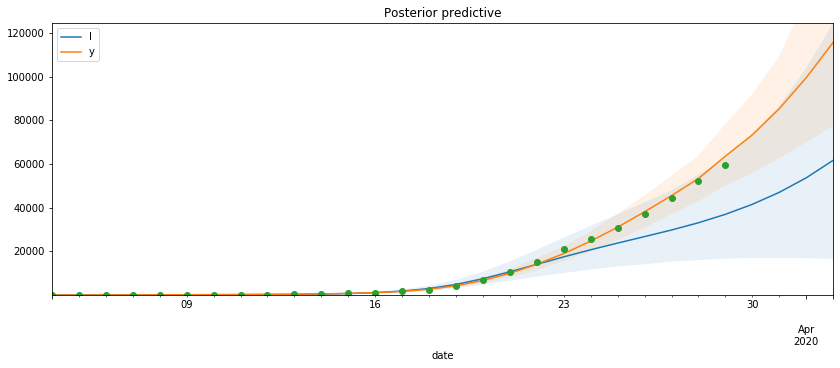

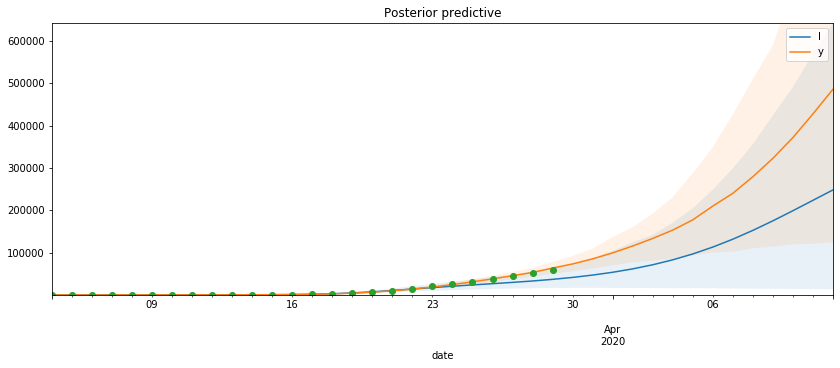

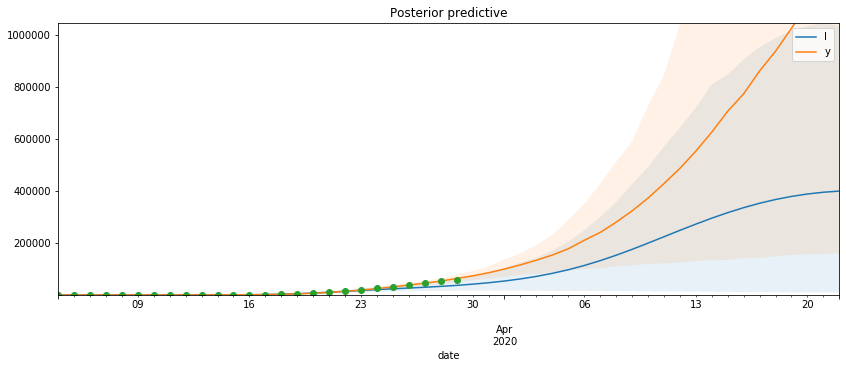

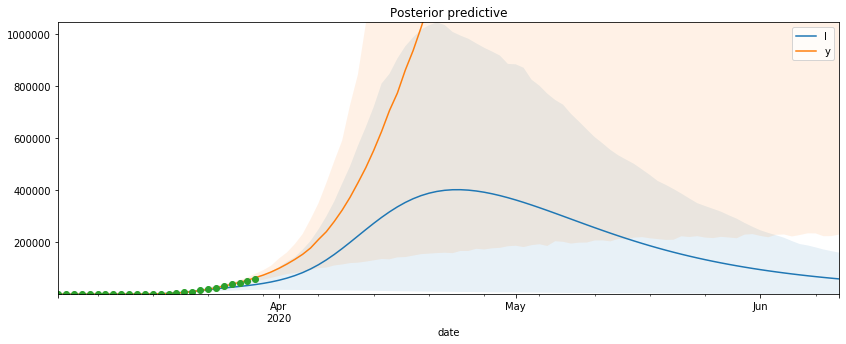

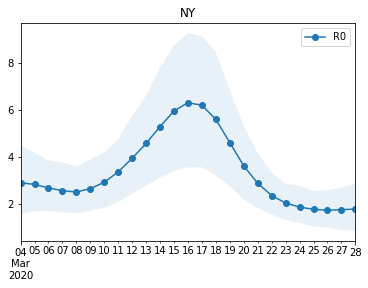

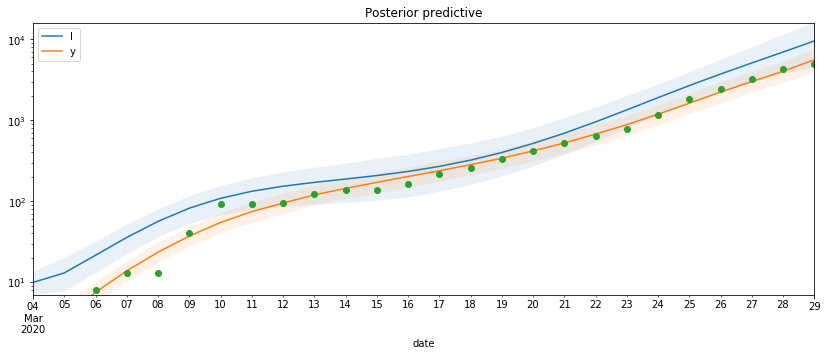

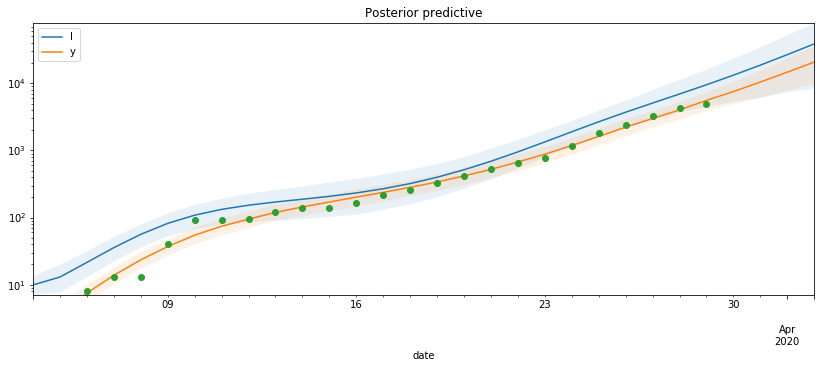

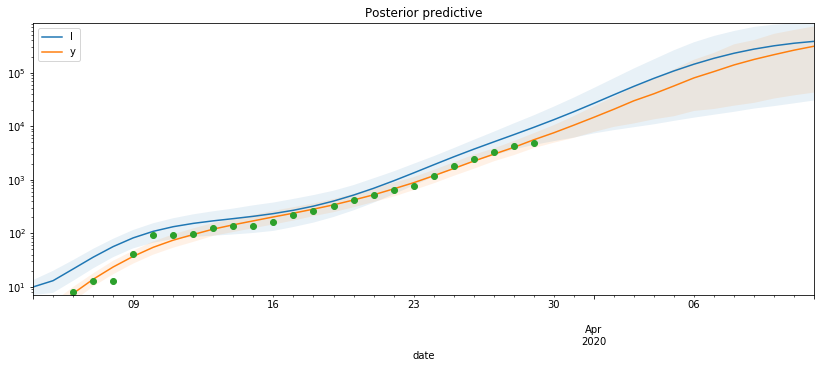

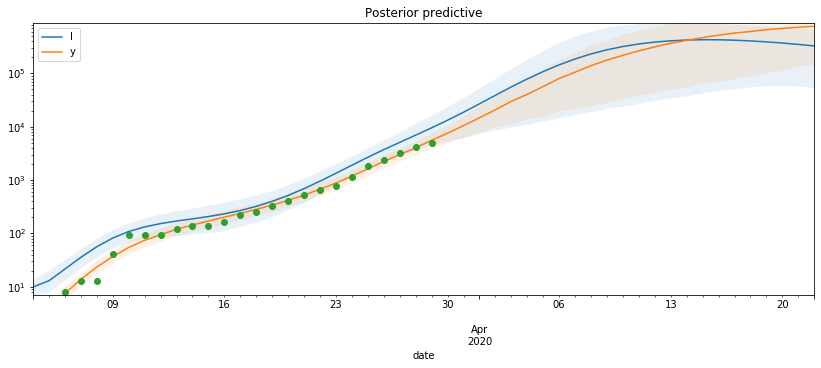

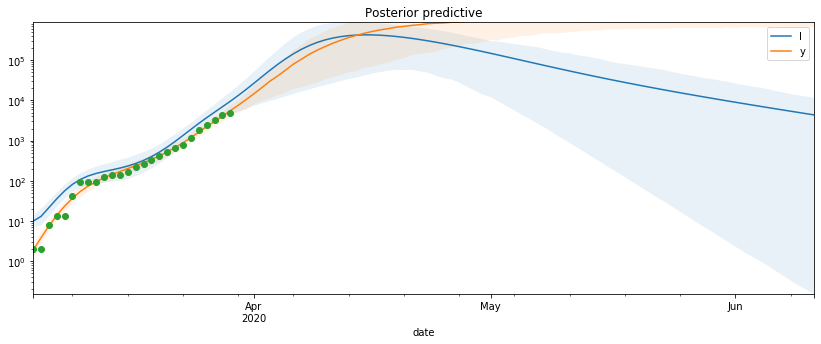

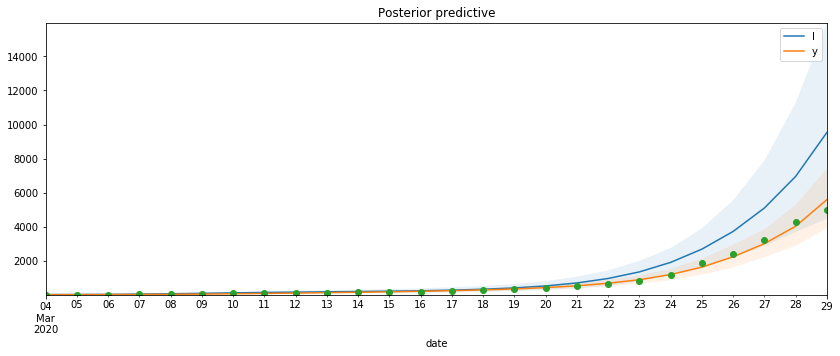

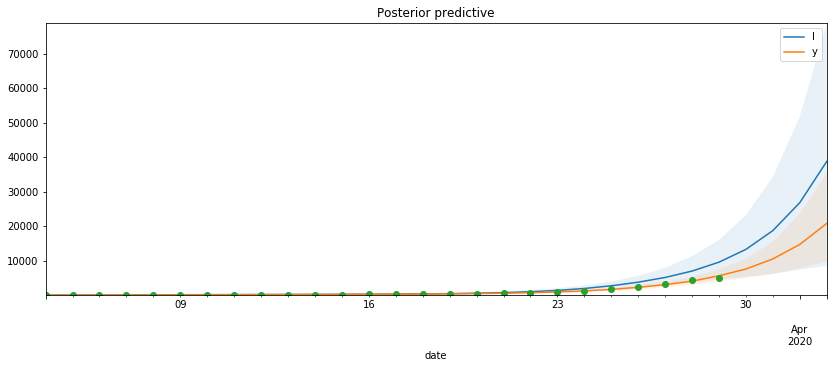

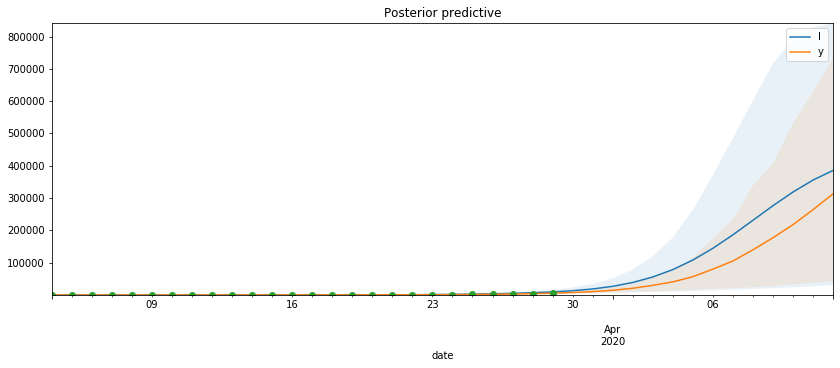

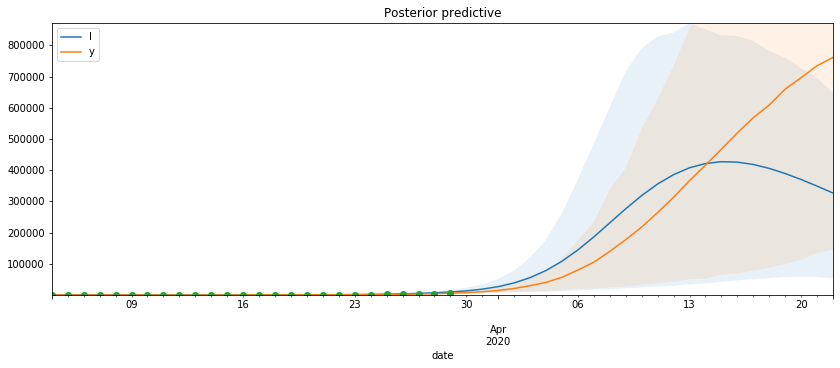

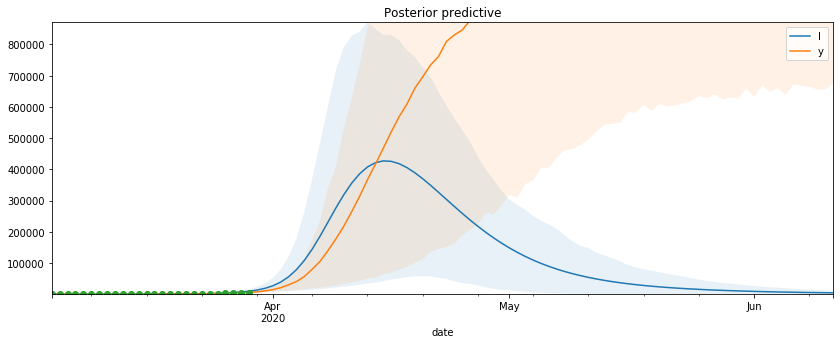

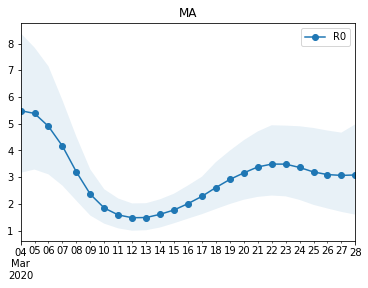

In [14]:

data, pop = load_data()

start = '2020-03-04'
places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY']

for place in places:
    
    confirmed = data[place].confirmed[start:]
    start_ = confirmed.index.min()

    T = len(confirmed)
    N = pop[place]

    mcmc_samples, post_pred_samples = load_samples(place)
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start_, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start_, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

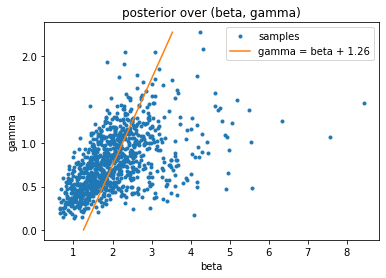

R0: 2.9294224


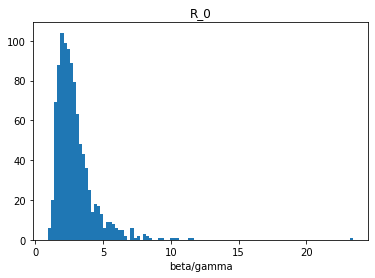

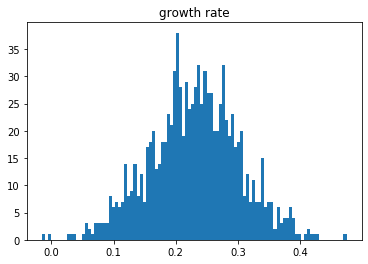

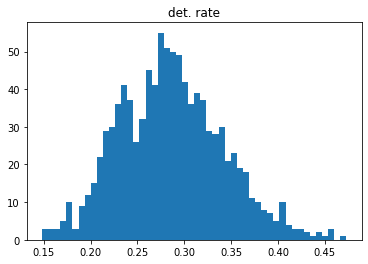

In [44]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    test_prior_predictive()

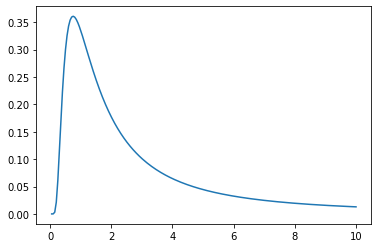

In [11]:
d = dist.Gamma(1, 1 * 1.5)
e = dist.TransformedDistribution(d, dist.transforms.PowerTransform(-1))
x = np.linspace(0, 10, 200)
plt.plot(x, np.exp(e.log_prob(x)))



In [42]:
mcmc_samples = None

place = 'WA'
filename = f'out/{place}_samples.npz'
x = np.load(filename, allow_pickle=True)
#print(x['arr_0']['E0'])
mcmc_samples = x['arr_0'].item()
post_pred_samples = x['arr_0'].item()

mcmc_samples['E0']

array([8.66874619e+01, 4.15219696e+02, 4.45294373e+02, 2.56993042e+02,
       7.04531937e+01, 1.18157928e+02, 1.36333282e+02, 1.07267029e+02,
       8.06847839e+01, 8.15182419e+01, 8.50297852e+01, 1.01856270e+02,
       1.20759430e+02, 1.11948647e+02, 1.02471603e+02, 8.55147476e+01,
       4.72280006e+01, 2.64801849e+02, 4.25228485e+02, 1.49566147e+02,
       7.14774170e+01, 2.46033691e+02, 1.93305496e+02, 1.57670837e+02,
       1.99327652e+02, 3.03032928e+02, 1.67519287e+02, 3.97491730e+02,
       1.51864357e+01, 7.93717117e+01, 1.51606049e+02, 1.44905502e+02,
       2.77630524e+02, 8.47063522e+01, 4.99812088e+01, 5.57977142e+01,
       7.15447006e+01, 2.27100334e+01, 4.41022491e+01, 1.07956108e+02,
       5.55965576e+02, 2.58322235e+02, 4.25230896e+02, 1.67635040e+02,
       1.59257479e+01, 5.08653526e+01, 4.43552132e+01, 7.02877808e+01,
       7.97777634e+01, 9.82648163e+01, 2.54315414e+01, 1.59228363e+02,
       1.51452240e+02, 6.13588982e+01, 1.80332428e+02, 8.58205719e+01,
      

In [15]:
1/.75

1.3333333333333333